# Comparative Politics and the Synthetic Control Method
### Abadie, Diamond and Hainmueller

This notebook reproduces the weights from the 2015 paper "Comparative Politics and the Synthetic Control Method" by Alberto Abadie, Alexis Diamond and Jens Hainmueller. The study data is contained in the file `../data/germany.csv` (more detailed information on this dataset is available in the appendix of the cited paper).

In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth

The study is carried out in two steps. In each step we prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

In the first run, the optimisation is carried out over the period 1981 to 1991, and the $V$ matrix obtained in this optimisation is then used in the second run, where the optimisation is carried out over the period 1960 to 1990. This serves to enforce that the predictor importances used in the final optimisation are those of the eighties.

In each case, we supply the `Dataprep` object to a `Synth` object. In the second run, we can provide a custom $V$ matrix with the `custom_V` option.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [2]:
df = pd.read_csv("../data/germany.csv")

dataprep_train = Dataprep(
    foo=df,
    predictors=["gdp", "trade", "infrate"],
    predictors_op="mean",
    time_predictors_prior=range(1971, 1981),
    special_predictors=[
        ("industry", range(1971, 1981), "mean"),
        ("schooling", [1970, 1975], "mean"),
        ("invest70", [1980], "mean"),
    ],
    dependent="gdp",
    unit_variable="country",
    time_variable="year",
    treatment_identifier="West Germany",
    controls_identifier=[
        "USA",
        "UK",
        "Austria",
        "Belgium",
        "Denmark",
        "France",
        "Italy",
        "Netherlands",
        "Norway",
        "Switzerland",
        "Japan",
        "Greece",
        "Portugal",
        "Spain",
        "Australia",
        "New Zealand",
    ],
    time_optimize_ssr=range(1981, 1991),
)

synth_train = Synth()
synth_train.fit(dataprep=dataprep_train)

In [3]:
dataprep = Dataprep(
    foo=df,
    predictors=["gdp", "trade", "infrate"],
    predictors_op="mean",
    time_predictors_prior=range(1981, 1991),
    special_predictors=[
        ("industry", range(1981, 1991), "mean"),
        ("schooling", [1980, 1985], "mean"),
        ("invest80", [1980], "mean"),
    ],
    dependent="gdp",
    unit_variable="country",
    time_variable="year",
    treatment_identifier="West Germany",
    controls_identifier=[
        "USA",
        "UK",
        "Austria",
        "Belgium",
        "Denmark",
        "France",
        "Italy",
        "Netherlands",
        "Norway",
        "Switzerland",
        "Japan",
        "Greece",
        "Portugal",
        "Spain",
        "Australia",
        "New Zealand",
    ],
    time_optimize_ssr=range(1960, 1990),
)

synth = Synth()
synth.fit(dataprep=dataprep, custom_V=synth_train.V)

In [4]:
synth.weights()

USA            0.216
UK             0.000
Austria        0.415
Belgium        0.000
Denmark        0.000
France         0.000
Italy          0.000
Netherlands    0.098
Norway         0.000
Switzerland    0.108
Japan          0.162
Greece         0.000
Portugal       0.000
Spain          0.000
Australia      0.000
New Zealand    0.000
Name: weights, dtype: float64

The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.216 \times \text{USA} + 0.415 \times \text{Austria} + 0.098 \times \text{Nederlands} + 0.108 \times \text{Switzerland} + 0.163 \times \text{Japan}.$$

The `path_plot` method shows the path of the treated unit and the synthetic control over time.

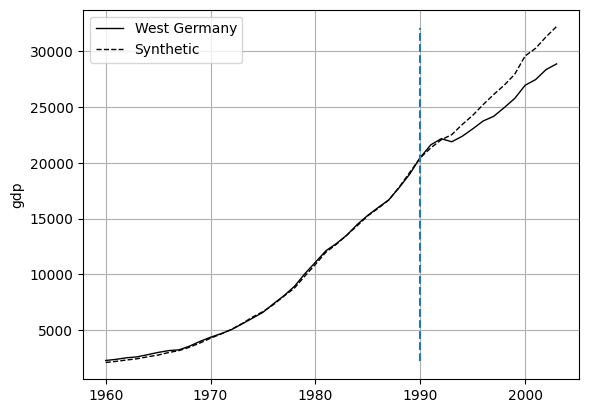

In [5]:
synth.path_plot(time_period=range(1960, 2004), treatment_time=1990)

The `gaps_plot` method shows the gaps (the difference between the treated unit and the synthetic control) over time.

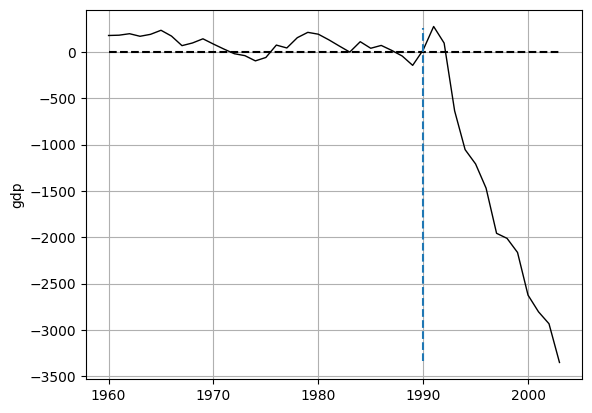

In [6]:
synth.gaps_plot(time_period=range(1960, 2004), treatment_time=1990)

Compute the average treatment effect on the treated unit (ATT) over the post-treatment time period. This method returns a standard error also.

In [7]:
synth.att(time_period=range(1990, 2004))

{'att': -1558.4329540422546, 'se': 317.5609062753852}

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [8]:
synth.summary()

,V,treated,synthetic,sample mean
gdp,0.261,15808.900,15782.157,13669.381
trade,0.199,56.778,56.999,59.831
infrate,0.178,2.595,3.442,7.617
special.1.industry,0.001,34.538,34.432,33.794
special.2.schooling,0.206,55.500,55.119,38.659
special.3.invest80,0.155,27.018,27.073,25.895
